<a href="https://colab.research.google.com/github/DavidePrati99/Deep-Learning-project-on-img-to-img/blob/main/Convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports for files
import glob # for getting filenames matching an expression
from os import path
# imports for images and plots
import PIL
from matplotlib import pyplot as plt
# imports for deep learning
import tensorflow as tf
from tensorflow import keras
# misc
import random

In [ ]:
# only for google drive linking (on Colab)
from google.colab import drive
# Link Google Drive account to use relative pathnames
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# See in the dark

## Dataset

Define the path to the directory containing the `Sony` folder

In [ ]:
#base_dir = './'
#base_dir = "A:/Launchpad/Deep learning project/SID/Data/dataset/"
#base_dir = "E:/Data/Deep Learning/See in the dark"
base_dir = './gdrive/MyDrive/Progetto Deep Learning/Learning-to-See-in-the-Dark/dataset/' # Davide (me lo scrivo sennò mi dimentico <3)
#base_dir = './gdrive/MyDrive/Data Science/Progetto Deep Learning/Learning-to-See-in-the-Dark/dataset/' # Edo
base_dir = path.normpath(base_dir)
print("Found Sony folder:", path.isdir(path.join(base_dir, './Sony/')))
print("Found Fuji folder:", path.isdir(path.join(base_dir, './Fuji/')))

Found Sony folder: True
Found Fuji folder: False


### Data input structure

Images file names are built like

```
AB_C_Ds.extension
```

- `A` (1 digit) is the number that discriminates the training, testing and validation sets
  - Training: starts with 0
  - Testing: starts with 1
  - Validation: starts with 2
- `B` (4 digits) is the identifier of the subject of the photo, photos with same B represents the same subject
- `C` (2 digits) is the shot number, but sometimes there is more than one shot with different exposure time and same shot number
- `D` is the exposure time in seconds

Images are divided at the root in two folders

- `short` for short exposure images, that are the network input
- `long` for long exposure images, that are the output ground truth

Ground truth images always have `C` = 00 and `D` = 10 or 30, there is only one shot per subject.

Input images typically has `C` between 00 and 09 and `D` = 0.1 but also 0.033 and 0.04 sometimes, images of the same subject are very very similar since all camera parameters are the same.

In [ ]:
dark_dir = path.normpath(path.join(base_dir, './Sony/short/png 8bit/'))
clear_dir = path.normpath(path.join(base_dir, './Sony/long/png 8bit/'))
print("dark_dir is valid:", path.isdir(dark_dir))
print("clear_dir is valid:", path.isdir(clear_dir))

dark_dir is valid: True
clear_dir is valid: True


In [ ]:
extension = ".png"

training_in = glob.glob(path.join(dark_dir, '0*' + extension))
print("Input training images found:", len(training_in))

testing_in = glob.glob(path.join(dark_dir, '1*' + extension))
print("Input testing images found:", len(testing_in))

validation_in = glob.glob(path.join(dark_dir, '2*' + extension))
print("Input validation images found:", len(validation_in))

Input training images found: 1865
Input testing images found: 598
Input validation images found: 234


We want the list of ground truth images to be of the same length of the input lists, in order to have a one-to-one correspondence with input and ground truth.
Given the image naming and that multiple input images can have a common ground truth image, we match couples by the image group identifier `A` and subject identifier `B`.

In [ ]:
def get_img_path_list_out(img_path_list_in: list[str]) -> list[str]:
    img_path_list_out = []
    for img_path in img_path_list_in:
        name = path.basename(img_path)
        extension = path.splitext(name)[1]
        out = glob.glob(path.join(clear_dir, name[0:5] + '*' + extension))[0]
        out = path.normpath(out)
        img_path_list_out.append(out)
    return img_path_list_out

training_out = get_img_path_list_out(training_in)
print("Ground truth training images have same length of input:", len(training_in)==len(training_out))

testing_out = get_img_path_list_out(testing_in)
print("Ground truth testing images have same length of input:", len(testing_in)==len(testing_out))

validation_out = get_img_path_list_out(validation_in)
print("Ground truth validation images have same length of input:", len(validation_in)==len(validation_out))

Ground truth training images have same length of input: True
Ground truth testing images have same length of input: True
Ground truth validation images have same length of input: True


In [ ]:
def print_matches(img_path_list_in: list[str], img_path_list_out: list[str]) -> None:
    n = max(len(img_path_list_in), len(img_path_list_out))
    for i in range(n):

        if (i >= len(img_path_list_in)):
            name_in = "NOT FOUND"
        else:
            name_in = path.basename(img_path_list_in[i])

        if (i >= len(img_path_list_out)):
            name_out = "NOT FOUND"
        else:
            name_out = path.basename(img_path_list_out[i])

        print(f"{name_in} -> {name_out}")

#print_matches(training_in, training_out)
#print_matches(testing_in, testing_out)
#print_matches(validation_in, validation_out)

### Images

All images have original height 2840 and width 4246.
`img_height` and `img_width` are the parameters for the network input size. We half the image size both for performance and for supporting input from not-so-good cameras.

In [ ]:
img_height = int(2840/10)
img_width = int(4246/10)
img_channels = 3

Image test

Path: gdrive/MyDrive/Progetto Deep Learning/Learning-to-See-in-the-Dark/dataset/Sony/long/png 8bit/00202_00_10s.png
Python data type of the image: <class 'PIL.Image.Image'>
Tensorflow tensor after tensor conversion: <dtype: 'uint8'> (284, 424, 3)
Image format: None
Image mode: RGB
Image size: (424, 284)
Height:  284
Width:  424
Channels:  3 ('R', 'G', 'B')


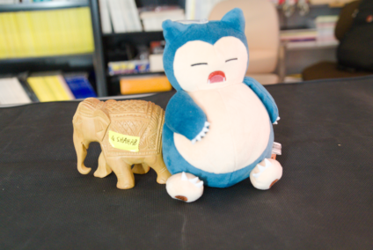

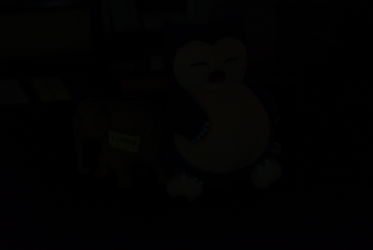

In [ ]:
index = random.randrange(len(training_out))

img_path = training_out[index]
print("Path:", img_path)

def read_image(image_path: str) -> PIL.Image.Image:
    return keras.preprocessing.image.load_img(
        image_path,
        target_size=(img_height, img_width),
        interpolation="bilinear"
    )

img = read_image(img_path)
print("Python data type of the image:", type(img))
img_tensor = tf.convert_to_tensor(img)
print("Tensorflow tensor after tensor conversion:", img_tensor.dtype, img_tensor.shape)
print("Image format:", img.format)
print("Image mode:", img.mode)
print("Image size:", img.size)
print('Height: ', img.height)
print('Width: ', img.width)
print('Channels: ', len(img.split()), img.getbands())

def resize_image(image: PIL.Image.Image, height=250):
    return(image.resize((int(height/image.height*image.width), height)))

#img.show() # for Python standard code
display(resize_image(img)) # for Python notebook

img_dark = read_image(training_in[index])
display(resize_image(img_dark))

### Tensorflow dataset

Define the type of the tensor to which the image will be converted to

In [ ]:
image_data_shape = (img_height, img_width, img_channels)
image_tensor_spec = tf.TensorSpec(
    shape = image_data_shape,
    dtype = tf.uint8
)
image_data_shape

(284, 424, 3)

The datasets created as follows will be an iterable of tuples `(image_in, image_out)`, where the images are loaded in memory only when necessary.

In [ ]:
# this function creates a dataset generator function
def get_dataset_generator(img_path_list_in: list[str], img_path_list_out: list[str]):

    # the dataset generator function must yield the elements to be fed to the network later
    def dataset_generator():
        # iterate until one of the two lists does not end, although in theory the lengths are equal
        for i in range(min(len(img_path_list_in), len(img_path_list_out))):
            # yield couples of input image and ground truth image
            # the image is a PIL image, that must be converted to tensor in order to be fed to the network
            yield tf.convert_to_tensor(read_image(img_path_list_in[i])), tf.convert_to_tensor(read_image(img_path_list_out[i]))

    return dataset_generator

dataset_training = tf.data.Dataset.from_generator(
    get_dataset_generator(training_in, training_out),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
# set cardinality
dataset_training = dataset_training.apply(tf.data.experimental.assert_cardinality(len(training_in)))

dataset_testing = tf.data.Dataset.from_generator(
    get_dataset_generator(testing_in, testing_out),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_testing = dataset_testing.apply(tf.data.experimental.assert_cardinality(len(testing_in)))

dataset_validation = tf.data.Dataset.from_generator(
    get_dataset_generator(validation_in, validation_out),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_validation = dataset_validation.apply(tf.data.experimental.assert_cardinality(len(validation_in)))

## Model training

In [ ]:
def generate_images(model, test_input, ground_truth):
  prediction = model(test_input, training=True)

  display_list = [test_input[0], ground_truth[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):
    print(title[i])
    display(tf.keras.preprocessing.image.array_to_img(display_list[i]))


In [ ]:
from keras.layers import LeakyReLU

In [ ]:
inputs = keras.Input(image_data_shape)
x = inputs
x = keras.layers.Conv2D(
    filters=3,
    kernel_size=3,
    padding='same', # è uno perché l'abbiamo calcolato
    strides=1)(x)
#x = keras.layers.Activation('relu')(x)
x = LeakyReLU(alpha=0.2)(x)

outputs = x
net = keras.Model(inputs, outputs)

In [ ]:
from skimage.metrics import structural_similarity as ssim

In [ ]:
def ssim_loss(y_true, y_pred):
    tf_true = tf.cast(y_true, tf.float32)
    tf_pred = tf.cast(y_pred, tf.float32)
    ssim_score = tf.reduce_mean(tf.image.ssim_multiscale(tf_true, tf_pred, max_val=255)) # differenza tra il valore di ground truth e l'output previsto
    return 1 - ssim_score # 1 - la differenza di prima

In [ ]:
#def ssim_loss(y_true, y_pred):
#    tf_true = tf.cast(y_true, tf.float32)
#    tf_pred = tf.cast(y_pred, tf.float32)

#   # Calcola l'SSIM tra le immagini
#   ssim_score = tf.py_function(func=ssim, inp=[tf_true, tf_pred], Tout=tf.float32)

    # Calcola la perdita come l'inverso dell'SSIM
#    loss = 1 - ssim_score

#    return loss

In [ ]:
net.compile(
    # loss = tf.keras.losses.MeanSquaredError(),  # L2
    # loss = tf.keras.losses.MeanAbsoluteError(), # L1
    loss=ssim_loss, # SSIM
    optimizer = keras.optimizers.Adam()
)

In [ ]:
dataset_training_test = dataset_training.batch(6)
dataset_training_test.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 284, 424, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 284, 424, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_validation_test = dataset_validation.batch(6)
dataset_validation_test.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 284, 424, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 284, 424, 3), dtype=tf.uint8, name=None))>



---



In [ ]:
import os

In [ ]:
checkpoint_dir = 'checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.ckpt')

In [ ]:
checkpoint_dir = 'checkpoint'
if os.path.exists(checkpoint_dir):
    print("La cartella dei checkpoint esiste.")
else:
    print("La cartella dei checkpoint non esiste.")

La cartella dei checkpoint esiste.


In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  # specifica il percorso in cui salvare i checkpoint
    save_weights_only=True,  # salva solo i pesi del modello invece dell'intero modello
    # save_best_only=True,  # salva solo il miglior checkpoint in base alla metrica specificata
    # monitor='val_loss',  # specifica la metrica da monitorare per selezionare il miglior checkpoint
    # mode='min'  # modalità di selezione del miglior checkpoint (minimo valore nella metrica)
    save_freq='epoch'
)

In [ ]:
checkpoint = tf.train.Checkpoint(model=net)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(latest_checkpoint)

None


In [ ]:
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint più recente caricato correttamente.")
    start_epoch = int(latest_checkpoint.split('-')[-1])
    print("L'ultima epoch valutata è la", start_epoch)
else:
    print("Nessun checkpoint trovato. Avvio l'addestramento da zero.")
    start_epoch = 0

Nessun checkpoint trovato. Avvio l'addestramento da zero.


In [ ]:
checkpoint_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: checkpoint_manager.save()
)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
num_epochs = 20  # Total number of epochs

In [ ]:
print_epoch_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print("Current epoch:", epoch+1)
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=2,  # Numero di epoch senza miglioramenti prima di interrompere l'addestramento
    monitor='val_loss',  # Misura da monitorare per determinare il miglioramento
    # monitor='loss',
    restore_best_weights=True  # Ripristina i pesi del modello al miglior punto
)

In [ ]:
history=net.fit(
        dataset_training_test,
        validation_data = dataset_validation_test,
        epochs=num_epochs,
        initial_epoch=start_epoch,  # Specifica l'epoch corrente come inizio
        callbacks=[checkpoint_callback, print_epoch_callback, early_stopping_callback]
    )

Current epoch: 1
Epoch 1/20
311/311 [==============================] - 3637s 12s/step - loss: nan - val_loss: nan
Current epoch: 2
Epoch 2/20
 15/311 [>.............................] - ETA: 54:40 - loss: nan

KeyboardInterrupt: ignored

In [ ]:
if early_stopping_callback.stopped_epoch > 0:
    print("Addestramento terminato prematuramente. Numero di epoch: ", early_stopping_callback.stopped_epoch)

In [ ]:
checkpoint_dir = 'checkpoint'
checkpoint_file = os.path.join(checkpoint_dir, 'checkpoint')

if os.path.exists(checkpoint_file):
    print("Il file di checkpoint è stato creato correttamente.")
else:
    print("Il file di checkpoint non è stato creato.")